# [튜토리얼4] 그래디언트 부스팅 트리(Gredient Boosted tree): 모델 이해하기

이번 튜토리얼의 목표는 다음과 같습니다:

* 부스팅 트리 모델을 해석하는 방법을 알아보겠습니다.
* 부스팅 트리 모델에 데이터셋을 적용해보겠습니다.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd

from IPython.display import clear_output

import tensorflow as tf
tf.random.set_seed(123)

import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

from numpy.random import uniform, seed
from scipy.interpolate import griddata

# 목차
1. 부스팅 트리를 해석하는 방법
2. 타이타닉 데이터셋 불러오기
3. 피쳐 열과 입력 함수를 만들고 에스티메이터(Estimator) 학습시키기
    - 3.1 데이터 전처리
    - 3.2 파이프라인 구축하기
    - 3.3 모델 학습시키기
4. 모델 해석과 시각화
    - 4.1 국소적(local) 해석
    - 4.2 전역적(global) 해석
        - 이익 기반 피쳐 중요도
        - DFC 절대값의 평균 구하기
        - 순열 피쳐 중요도
    - 4.3 모델 시각화
5. 결론

##  1. 부스팅 트리를 해석하는 방법

모델을 해석하는 데에는 다음의 두 가지 관점이 있습니다.

* **국소적(local) 해석**은 개별 데이터 수준에서 모델의 예측을 이해하는 것입니다 
* **전역적(global) 해석**은 모델을 전체적으로 이해하는 것을 의미합니다.

이러한 기법들은 머신러닝(ML) 실무자가 모델을 개발하는 데에 있어 편향과 버그를 탐지하는 데 도움이 될 수 있습니다.

국소적(local) 해석을 위해 각 객체(instance)당 기여도를 생성하고 시각화하는 방법을 학습할 것입니다. 이를 피쳐 중요도와 구별하기 위해 이러한 값을 **DFCs**(directional feature contributions)라고 합니다.

전역적(global) 해석을 위해 이익 기반 피쳐 중요도와 순열 피쳐 중요도를 검색, 시각화해보고 집계된 DFCs를 표시합니다.

## 2. 타이타닉 데이터셋 불러오기

성별, 나이, 클래스 등의 특성을 고려하여 승객 생존을 예측하는 것이 목표인 타이타닉 데이터 세트를 사용할 것입니다.

In [16]:
# 데이터셋을 불러옵니다.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

# 불러온 데이터 중 500개의 학습 데이터와 200개의 검증 데이터를 사용합니다.
dftrain = dftrain.iloc[:500]
y_train = y_train.iloc[:500]
dfeval = dfeval.iloc[:200]
y_eval = y_eval.iloc[:200]

## 3. 피쳐 열과 입력 함수를 만들고 에스티메이터(Estimator) 학습시키기

### 3.1 데이터 전처리

숫자 열은 있는 그대로 사용하고 범주형 변수는 원-핫 인코딩을 통해 변환하여 피쳐 열을 생성합니다.

In [17]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(
        fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # 범주형 피쳐는 원-핫 인코딩이 필요합니다.
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

### 3.2 파이프라인 구축하기

판다스(Pandas)의 데이터를 직접적으로 읽어오기 위해 [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API에 있는 `from_tensor_slices` 메서드를 사용해서 입력 함수를 만듭니다.

In [18]:
# 데이터셋이 작으므로 모든 배치(batch)를 사용합니다.
NUM_EXAMPLES = len(y_train)

# 입력 함수 만들기
def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # n_epochs로 지정한만큼 데이터셋을 반복해서 학습합니다
        dataset = (dataset
            .repeat(n_epochs)
            .batch(NUM_EXAMPLES))
        return dataset
    return input_fn

# 훈련 데이터와 검증 데이터의 입력 함수입니다.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

### 3.3 모델 학습시키기

In [19]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # DFC를 가져오려면 center_bias = True로 설정해서
  # 모델이 피쳐를 적용하기 전에 초기 예측을 하도록 합니다
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)

# 모델을 학습시킵니다.
est.train(train_input_fn, max_steps=100)

# 모델 검증하기
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.810000
accuracy_baseline,0.630000
auc,0.846471
auc_precision_recall,0.833636
average_loss,0.445811
global_step,100.000000
label/mean,0.370000
loss,0.445811
precision,0.750000
prediction/mean,0.389551


데이터의 크기가 메모리에 맞으면 `boosted_trees_classifier_train_in_memory` 함수를 이용하는 것이 성능상 더 좋습니다. 그러나 학습 시간이 길어도 문제가 없거나 데이터셋이 너무 커서 분산 학습을 하려고 한다면 위에 나와 있는 `tf.estimator.BoostedTrees` API를 사용합니다.

이 메소드는 전체 데이터셋을 다루므로 입력 데이터를 배치화하지 않습니다.

In [20]:
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1

# 인메모리 입력 함수는 배치를 사용하지 않습니다.
def make_inmemory_train_input_fn(X, y):
    y = np.expand_dims(y, axis=1)
    def input_fn():
        return dict(X), y
    return input_fn
train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)

# 모델을 학습시킵니다.
est = tf.estimator.BoostedTreesClassifier(
    feature_columns, 
    train_in_memory=True, 
    **in_memory_params)

est.train(train_input_fn)
clear_output()
print(est.evaluate(eval_input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-09-15T04:47:20Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpb9ju6lp4/model.ckpt-153
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-09-15-04:47:21
INFO:tensorflow:Saving dict for global step 153: accuracy = 0.79, accuracy_baseline = 0.63, auc = 0.8381596, auc_precision_recall = 0.83368945, average_loss = 0.45019126, global_step = 153, label/mean = 0.37, loss = 0.45019126, precision = 0.7222222, prediction/mean = 0.38744187, recall = 0.7027027
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 153: /tmp/tmpb9ju6lp4/model.ckpt-153
{'accuracy': 0.79, 'accuracy_

## 4. 모델 해석과 시각화

### 4.1 국소적(local) 해석

[Palczewska et al](https://arxiv.org/pdf/1312.1121.pdf)과 Saabas의 [랜덤 포레스트 해석](http://blog.datadive.net/interpreting-random-forests/)처럼 개별 예측을 설명하는 DFC를 출력해보겠습니다.(이 방법은  사이킷런(scikit-learn)에 있는 [`treeinterpreter`](https://github.com/andosa/treeinterpreter) 패키지의 랜덤 포레스트에서도 사용할 수 있습니다.) 

DFCs는 다음 코드를 통해 생성됩니다.

`pred_dicts = list(est.experimental_predict_with_explanations(pred_input_fn))`

In [21]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpb9ju6lp4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f38980ea320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph

In [22]:
# DFC를 판다스 데이터프레임으로 생성합니다.
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
sex,200.0,0.001670,0.103550,-0.103315,-0.073654,-0.072339,0.132367,0.157284
age,200.0,-0.019262,0.072137,-0.226972,-0.066870,-0.045180,0.019839,0.320828
class,200.0,0.016173,0.091716,-0.101322,-0.048688,-0.044626,0.024506,0.222744
fare,200.0,0.012025,0.090020,-0.204258,-0.044252,-0.016874,0.056982,0.228670
deck,200.0,-0.010853,0.025240,-0.077943,-0.025545,-0.015997,0.002337,0.130762
embark_town,200.0,-0.010323,0.022131,-0.089290,-0.020259,-0.017413,-0.003304,0.049596
n_siblings_spouses,200.0,-0.000607,0.026970,-0.174164,-0.000102,0.003500,0.006018,0.049479
alone,200.0,0.000478,0.006414,-0.014559,-0.002449,0.001512,0.001942,0.018162
parch,200.0,0.000141,0.006844,-0.096104,0.000466,0.000545,0.000911,0.001054


DFCs의 좋은 점은 기여의 합 + 편향이 주어진 데이터 대한 예측과 같다는 것입니다.

In [23]:
# DFC의 합 + 편향 == 예측 확률
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

개별 승객에 대한 DFC를 시각화합니다. 기여도의 방향성을 기준으로 색을 부호화하여 그림을 보기 좋게 만들고 그림에 피쳐 값을 추가합니다.

In [24]:
# 시각화의 표준 양식입니다.
def _get_color(value):
    """양의 DFC를 초록색으로 음의 DFC를 빨간색으로 표시합니다."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """피쳐 값을 플롯의 왼쪽에 배치합니다."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
    TOP_N = 8 # 위에서부터 8개의 피쳐를 봅니다.
    sorted_ix = example.abs().sort_values()[-TOP_N:].index  # 중요도를 정렬합니다.
    example = example[sorted_ix]
    colors = example.map(_get_color).tolist()
    ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
    ax.grid(False, axis='y')
    ax.set_yticklabels(ax.get_yticklabels(), size=14)

    # 피쳐 값들을 넣습니다.
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
    return ax

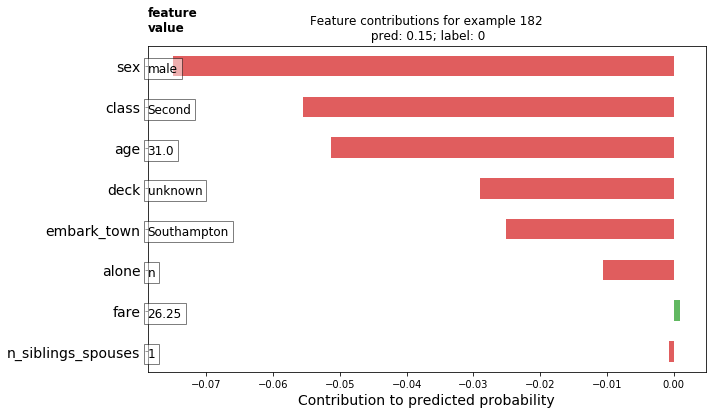

In [25]:
# 시각화 결과입니다.
ID = 182
example = df_dfc.iloc[ID]  # 검증 데이터셋에서 i번째 데이터를 선택합니다.
TOP_N = 8  # 위에서 부터 8개의 피쳐를 확인합니다.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

더 큰 기여도는 모델의 예측에 더 큰 영향을 미칩니다. 음의 기여는 이 예제의 피쳐 값이 모델의 예측력을 감소시킨 반면 양의 기여값은 모델의 예측력을 증가시켰음을 나타냅니다.

또한 바이올린 플롯으로 데이터의 DFC와 전체 분포를 비교해볼 수 있습니다.

In [26]:
# 시각화의 표준 양식입니다
def dist_violin_plot(df_dfc, ID):
    # plot의 크기를 설정합니다.
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # 데이터 프레임을 만듭니다.
    TOP_N = 8  # 상위를 차지한 8개 피쳐를 확인합니다.
    example = df_dfc.iloc[ID]
    ix = example.abs().sort_values()[-TOP_N:].index
    example = example[ix]
    example_df = example.to_frame(name='dfc')

    # 전체 분포에 대한 기여도를 넣습니다.
    parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
    face_color = sns_colors[0]
    alpha = 0.15
    for pc in parts['bodies']:
        pc.set_facecolor(face_color)
        pc.set_alpha(alpha)

    # 피쳐 값을 넣습니다.
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

    # 국소적 기여도를 넣습니다.
    ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')

    # 범례를 설정합니다.
    ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
    legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
    legend.get_frame().set_facecolor('white')

    # 플롯을 구성합니다.
    ax.set_yticks(np.arange(example.shape[0]))
    ax.set_yticklabels(example.index)
    ax.grid(False, axis='y')
    ax.set_xlabel('Contribution to predicted probability', size=14)

우리의 데이터에 대한 그림을 그려봅시다.

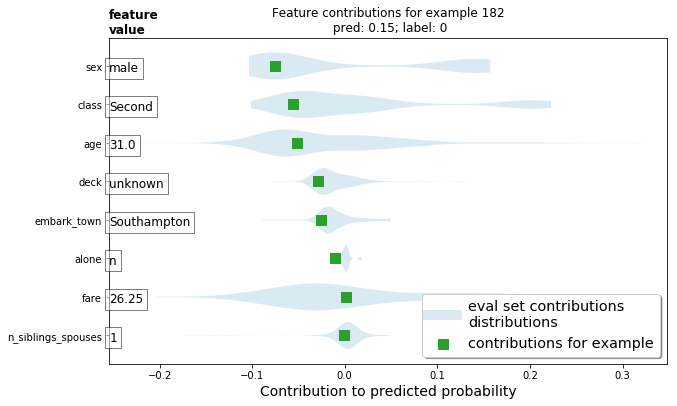

In [27]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

[LIME](https://github.com/marcotcr/lime)이나 [shap](https://github.com/slundberg/shap)과 같은 도구를 이용하여 모델에 대한 개별 예측을 이해하는 데 도움이 될 수 있습니다.

### 4.2 전역적(global) 해석

국소적 해석과 같은 개별적인 예측말고 모델을 전체적으로 이해해야 할 수도 있습니다. 이를 위해서는 다음과 같은 정보를 사용합니다:

* `est.experimental_feature_importances`을 사용하여 계산한 이익 기반(gain-based) 피쳐 중요도
* `est.experimental_predict_with_explanations`을 사용하여 집계한 DFC
* 순열(permutation) 피쳐 중요도

이익 기반 피쳐 중요도는 특정 피쳐에서 분할할 때의 손실 변화를 측정합니다

반면에 순열 피쳐 중요도는 각 피쳐를 하나씩 섞어 검증 데이터에 대한 모델의 성능을 평가하고 섞인 피쳐로 인한 모델 성능의 변화를 관찰하며 중요도를 계산합니다.

일반적으로 이익 기반 피쳐 중요도보다 순열 피쳐 중요도가 더 선호됩니다. 하지만 두 방법 모두 측정 규모 또는 범주 수에 따라 잠재적인 예측 변수가 달라지거나 피쳐들이 상관관계가 있는 경우에는 신뢰할 수 없습니다.

#### - 이익 기반 피쳐 중요도

텐서플로우 부스팅 트리 에스티메이터에는 이익 기반 피쳐 중요도를 계산하는`est.experimental_feature_importances`메소드가 내장되어 있습니다.

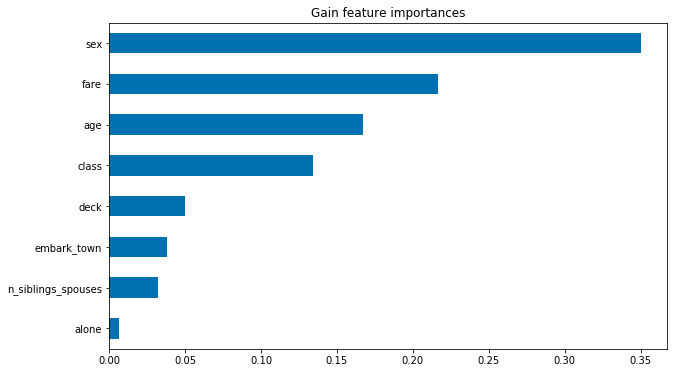

In [28]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# 중요도를 시각화합니다.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

#### - DFC 절대값의 평균구하기

DFC의 절대값의 평균을 구하여 전역적 수준에서의 영향력을 이해할 수 있습니다.

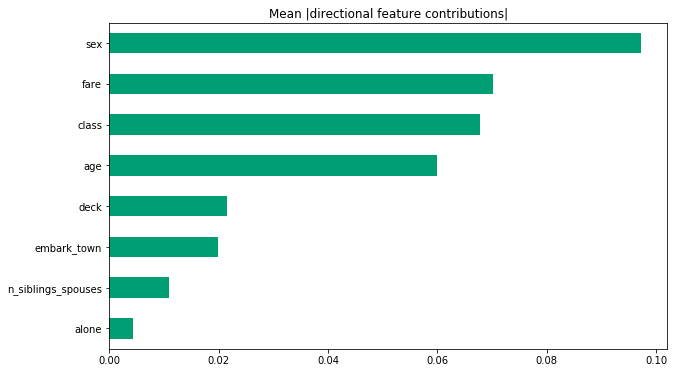

In [29]:
# 플롯 그리기
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  #절대값으로 평균을 구하고 정렬합니다.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

피쳐 값이 변함에 따라 DFC가 어떻게 달라지는지도 확인할 수 있습니다.

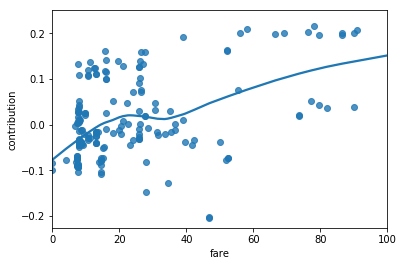

In [30]:
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()

#### - 순열 피쳐 중요도

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-09-15T04:47:52Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpb9ju6lp4/model.ckpt-153
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-09-15-04:47:52
INFO:tensorflow:Saving dict for global step 153: accuracy = 0.79, accuracy_baseline = 0.63, auc = 0.8381596, auc_precision_recall = 0.83368945, average_loss = 0.45019126, global_step = 153, label/mean = 0.37, loss = 0.45019126, precision = 0.7222222, prediction/mean = 0.38744187, recall = 0.7027027
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 153: /tmp/tmpb9ju6lp4/model.ckpt-153
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-09-15T04:47:53Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from 

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 153: /tmp/tmpb9ju6lp4/model.ckpt-153
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-09-15T04:48:04Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpb9ju6lp4/model.ckpt-153
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-09-15-04:48:05
INFO:tensorflow:Saving dict for global step 153: accuracy = 0.78, accuracy_baseline = 0.63, auc = 0.8043222, auc_precision_recall = 0.79841125, average_loss = 0.48790786, global_step = 153, label/mean = 0.37, loss = 0.48790786, precision = 0.734375, prediction/mean = 0.37988845, recall = 0.6351351
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 153: /tmp/tmpb9ju6lp4/model.ckpt-153
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at

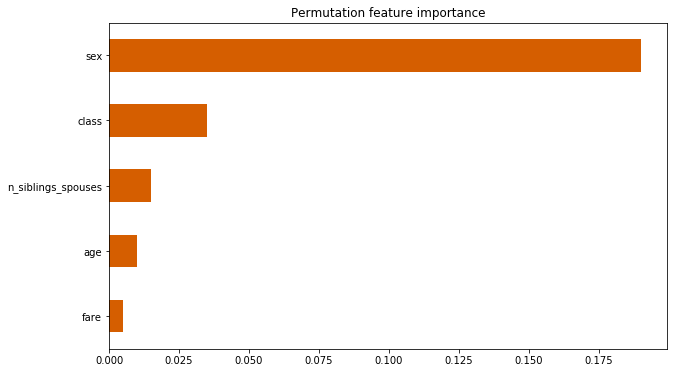

In [31]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """컬럼 별로 값들을 shuffle(섞고) 검증 데이터에서의 영향을 확인해봅니다.
    source: http://explained.ai/rf-importance/index.html
    """
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """텐서플로우 에스티메이터 정확도"""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()

### 4.3 모델 시각화

먼저 다음 공식을 사용하여 훈련 데이터를 생성, 사용해봅시다:

$$z=x* e^{-x^2 - y^2}$$

여기서 \(z\)는 예측하려는 종속 변수이고 \(x\) 와 \(y\)는 피쳐입니다.

In [32]:
# 가짜 데이터를 만듭니다.
seed(100)

#500개의 점
npts = 200
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)
xy = np.zeros((2,np.size(x)))
xy[0] = x
xy[1] = y
xy = xy.T

In [33]:
# 훈련 데이터를 준비합니다.
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

xi = np.linspace(-2.0, 2.0, 50),
yi = np.linspace(-2.1, 2.1, 60),
xi,yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
})
predict_shape = xi.shape

In [34]:
def plot_contour(x, y, z, **kwargs):
    # 데이터를 격자화(grid)합니다.
    plt.figure(figsize=(10, 8))
    # 격자화한 데이터에 등고선을 그리고 동일하지 않은 데이터 지점에 점을 표시합니다.
    CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
    CS = plt.contourf(x, y, z, 15,
                    vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
    plt.colorbar(CS)  # 컬러바를 그립니다.
    # 데이터 포인트들을 그립니다.
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)

함수를 시각화할 수 있습니다. 빨간색은 더 큰 함수 값에 해당합니다.

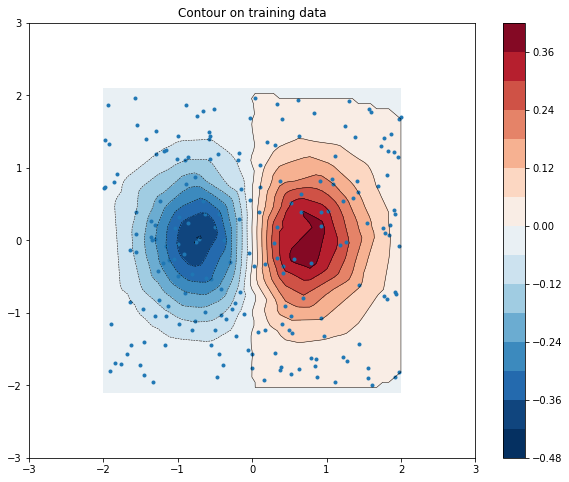

In [35]:
zi = griddata(xy, z, (xi, yi), method='linear', fill_value='0')
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title('Contour on training data')
plt.show()

In [36]:
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')]

In [37]:
def predict(est):
    """주어진 에스티메이터로 예측한 값"""
    predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
    preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
    return preds.reshape(predict_shape)

먼저 선형 모델에 적용해봅시다.

In [38]:
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=100)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpca6u25zt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f388bd38588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
Instructions for updat

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpca6u25zt/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


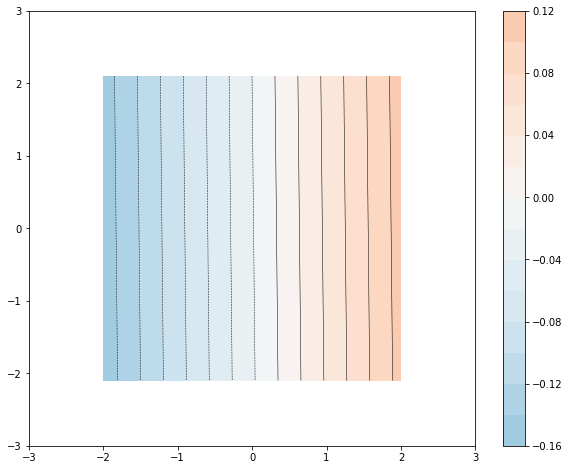

In [39]:
plot_contour(xi, yi, predict(est))

잘 맞지 않습니다. 다음으로 GBDT 모델에 적용시키고 모델이 함수에 얼마나 적합한지 알아보겠습니다.

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4trcvpq6/model.ckpt-5
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


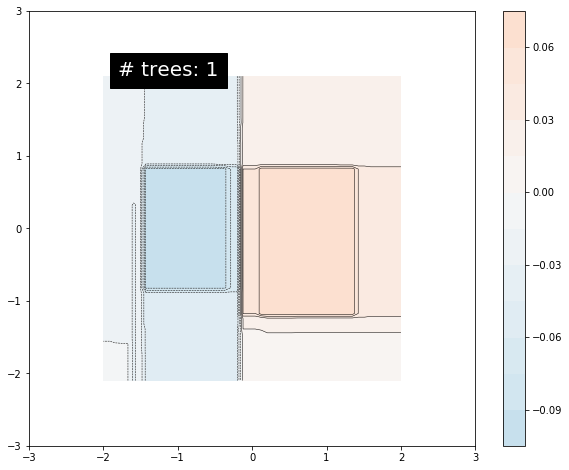

In [40]:
n_trees = 1 #@param {type: "slider", min: 1, max: 80, step: 1}

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=5)
clear_output()
plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
plt.show()

메모리 제한으로 인해 트리 수와 데이터의 수를 증가시킬 수 없지만 만약 트리와 데이터의 수를 크게 증가시키면 모델의 예측이 기본 함수에 점점 가까워지는 것을 확인할 수 있습니다.

![](https://www.tensorflow.org/images/boosted_trees/boosted_trees_ntrees.gif)

## 8. 결론

이번 튜토리얼에서는 부호화된 피쳐 기여도와 피쳐 중요도 함수를 사용하여 부스팅 트리 모델을 해석하는 방법을 배웠습니다. 이러한 기법은 피쳐가 모델의 예측에 어떤 영향을 미치는지에 대한 인사이트(insight)을 제공합니다.

# Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.